# Learning Methylated Sequence to Dyad Relationship
Train a neural network to discover the relationship between 6-letter methylated sequences and dyad positions.

In [50]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from icecream import ic

from ChromatinFibers import simulate_chromatin_fibers, encode_seq

In [52]:
# Define a simple model
class DyadPredictor(nn.Module):
    def __init__(self, seq_len=6, hidden_dim=32):
        super().__init__()
        # Embed 8-letter alphabet (upper/lower bases) to vectors
        self.embed = nn.Embedding(8, 8)
        
        # Process sequence with Conv1d
        self.conv = nn.Conv1d(8, hidden_dim, kernel_size=3, padding=1)
        # Final layer now outputs one logit per input position (seq_len)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * seq_len, 32),
            nn.ReLU(),
            nn.Linear(32, seq_len)  # Predict per-position logits
        )
    
    def forward(self, x):
        x = self.embed(x)  # (batch, seq_len) -> (batch, seq_len, 8)
        x = x.transpose(1, 2)  # (batch, 8, seq_len)
        x = self.conv(x)  # (batch, hidden_dim, seq_len)
        x = x.flatten(1)  # (batch, hidden_dim * seq_len)
        x = self.fc(x)
        return x  # logits (no sigmoid) for BCEWithLogitsLoss

In [56]:
# Prepare training data
# Example: create seq_len windows and per-position binary dyad labels
def generate_synthetic_data(n_samples=1000, seq_len=8):
    """Simulate fibers and return X_tensor (LongTensor, N x seq_len)
    and y_tensor (FloatTensor, N x seq_len) with 0/1 indicating dyads in the window.
    """
    dyads_list, sequences = simulate_chromatin_fibers(n_samples=n_samples, length=1000)
    X = []
    Y = []
    half = seq_len // 2
    for dyads, seq in zip(dyads_list, sequences):
        # pick first dyad or center if none
        dy_positions = np.asarray(dyads, dtype=int) if len(dyads) else np.array([], dtype=int)
        dy = int(dy_positions[0]) if dy_positions.size else len(seq) // 2
        start = max(0, min(dy - half, len(seq) - seq_len))
        window = seq[start:start + seq_len]
        encoded = encode_seq(window)
        X.append(encoded)
        # build binary label vector for dyads falling into window
        label = np.zeros(seq_len, dtype=np.float32)
        for d in dy_positions:
            if start <= d < start + seq_len:
                label[d - start] = 1.0
        Y.append(label)
    X_tensor = torch.LongTensor(X)
    y_tensor = torch.from_numpy(np.stack(Y).astype(np.float32))
    return X_tensor, y_tensor

X_tensor, y_tensor = generate_synthetic_data()
print(f"X shape: {X_tensor.shape}, y shape: {y_tensor.shape}")
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]



X shape: torch.Size([1000, 8]), y shape: torch.Size([1000, 8])


Epoch 10/50, Loss: 0.0004
Epoch 20/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0002
Epoch 30/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0001
Epoch 40/50, Loss: 0.0000
Epoch 40/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


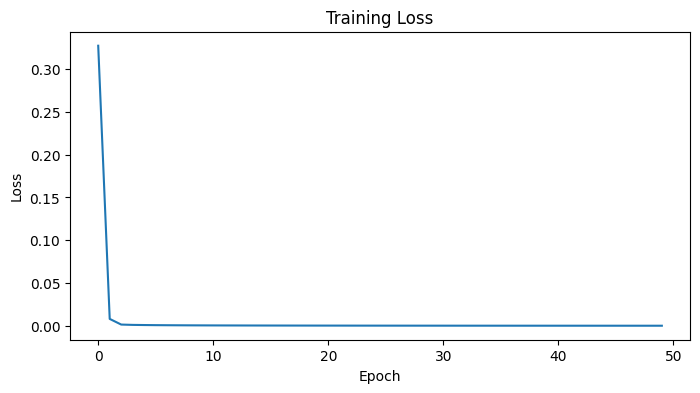

In [57]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate model with the actual sequence length from the data to avoid shape mismatches
model = DyadPredictor(seq_len=X_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
# per-position binary targets
epochs = 50
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        pred_logits = model(batch_X)  # shape (B, seq_len)
        loss = criterion(pred_logits, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [58]:
# Test the model
model.eval()
with torch.no_grad():
    test_seq = X_tensor[:1].to(device)  # shape (1, seq_len)
    logits = model(test_seq)  # (1, seq_len)
    probs = torch.sigmoid(logits)
    print(f"Test sequence (from data): {test_seq.cpu().numpy()}")
    print(f"Predicted per-position probabilities: {probs.cpu().numpy()}" )
    print(f"Predicted dyad positions (>=0.5): {np.where(probs.cpu().numpy().ravel() >= 0.5)[0]}" )

Test sequence (from data): [[2 0 3 3 2 0 3 3]]
Predicted per-position probabilities: [[6.0197763e-06 1.5177861e-06 8.7657014e-08 9.3440960e-08 9.9999845e-01
  5.6350524e-07 4.9503558e-07 3.5353710e-07]]
Predicted dyad positions (>=0.5): [4]


## To use with your data:
1. Provide your `methylated_sequence` (6 letters, encoded 0-5)
2. Provide corresponding `dyads` positions (normalized 0-1 or as indices)
3. Replace `generate_synthetic_data()` with your actual data
4. Adjust model architecture if needed

In [ ]:
test_dyads, test_sequence = generate_synthetic_data(n_samples=1, seq_len=8)